# 3.1 テキスト分類のファインチューニング

本 Notebook では、「1-1_text_classification_train.ipynb」にてファインチューニングしたモデルの評価を行います。

## 事前準備

ライブラリのインストールやデータセットの準備などを行います。

### (1) ライブラリのインストール

利用するライブラリをインストールします。

In [ ]:
# ライブラリのインストール
!pip install scikit-learn==1.2.2 transformers==4.38.2 datasets==2.18.0 japanize_matplotlib==1.1.3 fugashi==1.3.0 unidic_lite==1.0.8 fsspec==2023.6.0 gcsfs==2023.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 利用するライブラリのインポート
import os
import random
import sys

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import tqdm
from datasets import load_dataset
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    pipeline,
)
from transformers.trainer_utils import set_seed

In [ ]:
# 不要なwarningメッセージを除外
import warnings
warnings.simplefilter("ignore")

定数の定義を行います。




In [ ]:
# 定数の宣言
MODEL_INPUT = "./models"  # モデルの保存先
MAX_LENGTH = 512  # 入力の最大トークン
SEED_VALUE = 42  # 乱数SEED値の固定


# 乱数シード値をseed_valueに固定
def set_seed_function(seed_value: int = 0) -> None:
    """
    Set the seed value for reproducibility.

    Args:
        seed_value (int, optional): The seed value to set. Defaults to 0.
    """
    set_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


# 乱数シード値の固定
set_seed_function(SEED_VALUE)

以下のコードにて、保存済みのモデルを指定します。

モデルの保存先を変更した場合は、変数 `MODEL_INPUT` に変更後のパスを記入してください。変更していない場合は、そのままで問題ありません。

Google ドライブに保存する場合、「このノートブックに Google ドライブへのファイルへのアクセスを許可しますか？」という内容のポップアップが出現しますので、許可してください。



In [ ]:
# Google Colabで実行している場合、Googleドライブにモデルを読み込む準備をする
if "google.colab" in sys.modules:
    # Googleドライブのマウント
    from google.colab import drive
    drive.mount('/content/drive')
    # モデルを保存したフォルダを指定
    MODEL_INPUT = "drive/MyDrive/fine-turning_cookbook/chapter3/models/text_classification"
else:
    # モデルの保存先
    MODEL_INPUT = "./models/text_classification"

Mounted at /content/drive


### (2) データセットの準備

今回は、 Hugging Face で公開されているデータセットを利用します。

モデル評価用の test データが公開されていませんので、validation データにて評価を行います。

* URL: https://huggingface.co/datasets/shunk031/JGLUE

In [ ]:
# データセットの読み込み
valid_dataset = load_dataset("shunk031/JGLUE", name="MARC-ja", split="validation")

# データセットの概要を表示する
print("評価データ")
print(valid_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

評価データ
Dataset({
    features: ['sentence', 'label', 'review_id'],
    num_rows: 5654
})


## 評価

ファインチューニングしたモデルを評価します。

### (1) ファインチューニング済みモデルとトークナイザの読み込み

トークナイザとモデルを準備します。

In [ ]:
# 利用するデバイスの確認（GPU or CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの読み込み
model = (AutoModelForSequenceClassification
    .from_pretrained(MODEL_INPUT, ignore_mismatched_sizes=True)
    .to(device))

# tokenizerの読み込み
tokenizer = AutoTokenizer.from_pretrained(MODEL_INPUT)

### (2) 推論

パイプライン (Pipelines) を用いて推論を実行します。

In [ ]:
# Pipelinesの定義
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

In [ ]:
# 動作確認を行う

# レビューのサンプル
sample_review = [
    "このブレンダーは本当に素晴らしいです！使いやすく、パワフルで、朝のスムージーや夕食のスープ作りがこれまでになく簡単になりました。おすすめです！",
    "清掃が非常に困難で、部品が取り外しにくいです。がっかりしました。",
]
# 推論実行
sample_results = pipe(sample_review)

# 結果の表示
for i in range(len(sample_review)):
    print(f"レビュー: {sample_review[i]}")
    print(f"推論結果: {sample_results[i]['label']}")
    print(f"スコア: {sample_results[i]['score']:.4f}")
    print()


レビュー: このブレンダーは本当に素晴らしいです！使いやすく、パワフルで、朝のスムージーや夕食のスープ作りがこれまでになく簡単になりました。おすすめです！
推論結果: positive
スコア: 0.9992

レビュー: 清掃が非常に困難で、部品が取り外しにくいです。がっかりしました。
推論結果: negative
スコア: 0.9946



変数 `pipe` にまとめてレビュー文章を渡すこともできますが、多くのデータを一度に展開するとメモリの消費が大きいので、1行ずつ処理します。

In [ ]:
# 　ラベルの設定
class_label = valid_dataset.features["label"]

# 推論結果を格納する辞書の定義
results = {
    "review_id": [],
    "review": [],
    "true_label": [],
    "pred_label": [],
    "pred_score": [],
    "result": [],
}

# 1レビューずつ推論を行う
for i, example in tqdm.tqdm(enumerate(valid_dataset)):
    prediction = pipe(example["sentence"])[0]

    results["review_id"].append(example["review_id"])
    results["review"].append(example["sentence"])
    results["true_label"].append(class_label.int2str(example["label"]))
    results["pred_label"].append(prediction["label"])
    results["pred_score"].append(prediction["score"])
    results["result"].append(
        "correct" if class_label.int2str(example["label"]) == prediction["label"] else "incorrect"
    )


5654it [01:21, 68.99it/s]


### (3) 精度の評価

推論した結果を評価します。

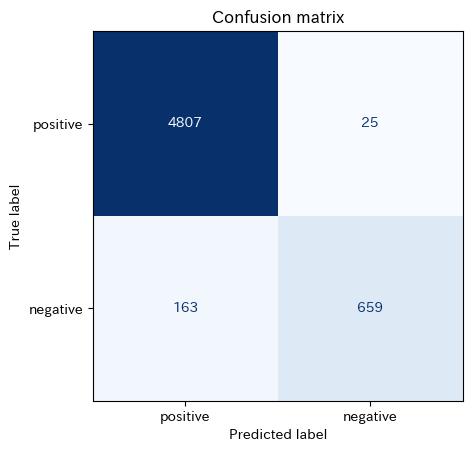

In [ ]:
# 混同行列による評価
def plot_confusion_matrix(y_pred: list, y_true:list, labels:list) -> None:
    """
    混同行列の可視化を行う

    Args:
        y_pred (list): 予測したラベル
        y_true (list): 正解ラベル
        labels (list): ラベルのリスト

    Returns:
        None
    """
    _labels = [label for label in labels if label != "neutral"]
    cm = confusion_matrix(y_true, y_pred, labels=_labels)

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=_labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title("Confusion matrix")
    plt.rcParams["font.size"] = 20
    plt.show()

plot_confusion_matrix(results["pred_label"], results["true_label"], class_label.names)

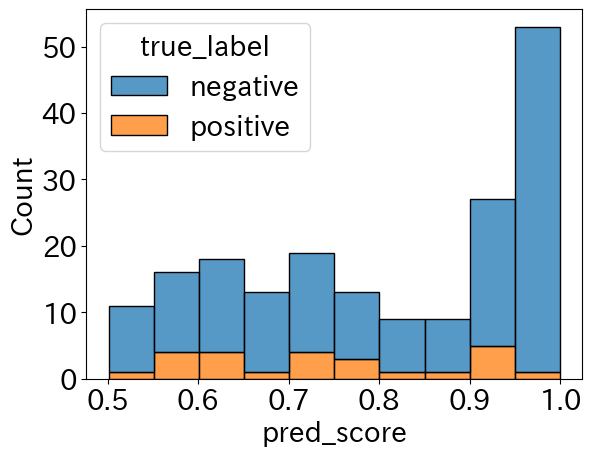

In [ ]:
# 推論を誤ったレビューとそのスコアの分布を確認する
results_df = pd.DataFrame(results)
errors = results_df[results_df["true_label"] != results_df["pred_label"]]

sns.histplot(errors, x="pred_score", hue="true_label", bins=10, multiple="stack")
plt.rcParams["font.size"] = 15
plt.show()

In [ ]:
# 正解がポジティブで、誤った予測がネガティブのデータの上位10件を確認する
_errors = errors.sort_values("pred_score", ascending=False)

false_negative = _errors[(_errors["true_label"] == "positive") & (_errors["pred_label"] == "negative")]
false_negative.head(3)

,review_id,review,true_label,pred_label,pred_score,result
5365,R1UJ9XCFY25PEU,終始、何かしらを批判し、内容はおいてけぼりの、クソB級映画です。でも、そんなチームアメリカが...,positive,negative,0.949960,incorrect
2558,R2JHYGPL8NAMPK,24見ちゃうとねぇ。。。他のドラマやら、映画。。見れなくなります。24の面白さが500％なの...,positive,negative,0.949070,incorrect
5113,R2VMJBKXG7R9F5,大体は良いのですが明らかな選曲ミスは「bring him home」アレンジがよければもっと...,positive,negative,0.937103,incorrect


In [ ]:
# トークン長ごとの正解率を確認するために、レビューごとのトークン長を取得する
def tokenize_dataset(example) -> dict:
    """
    入力データをトークンIDに変換する

    Args:
        example (dict): 入力文とラベルを含む辞書(トークナイズ化対象のデータセット)

    Returns:
        dict: トークンIDに変換された入力文とラベルを含む辞書
    """

    example_output = tokenizer(example["sentence"], truncation=True)
    example_output["label"] = example["label"]
    return example_output


# トークン化の実行
tokenized_valid_datasets = valid_dataset.map(tokenize_dataset, batched=True)

# レビューのトークン長を格納
results_df["token_length"] = [len(tokenizer.tokenize(example["sentence"])) for example in tokenized_valid_datasets]

Parameter 'function'=<function tokenize_dataset at 0x7c755a0f1ea0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/5654 [00:00<?, ? examples/s]

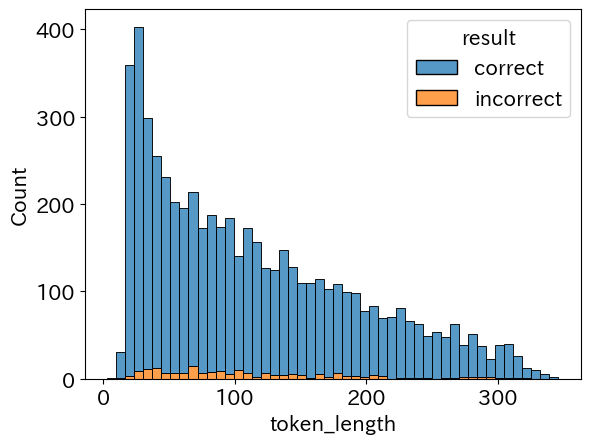

In [ ]:
# トークン長ごとの正解数と不正解数の分布を確認
sns.histplot(results_df, x="token_length", hue="result", bins=50, multiple="stack")
plt.rcParams["font.size"] = 15
plt.show()


レビューごとの推論結果の詳細を確認したい場合は、以下のコードのコメントアウトを外し、推論結果の csv データをご確認ください。

In [ ]:
# # 推論結果を csv に保存
# results_df.to_csv("results.csv", index=False, encoding="utf-8-sig")